4378.5


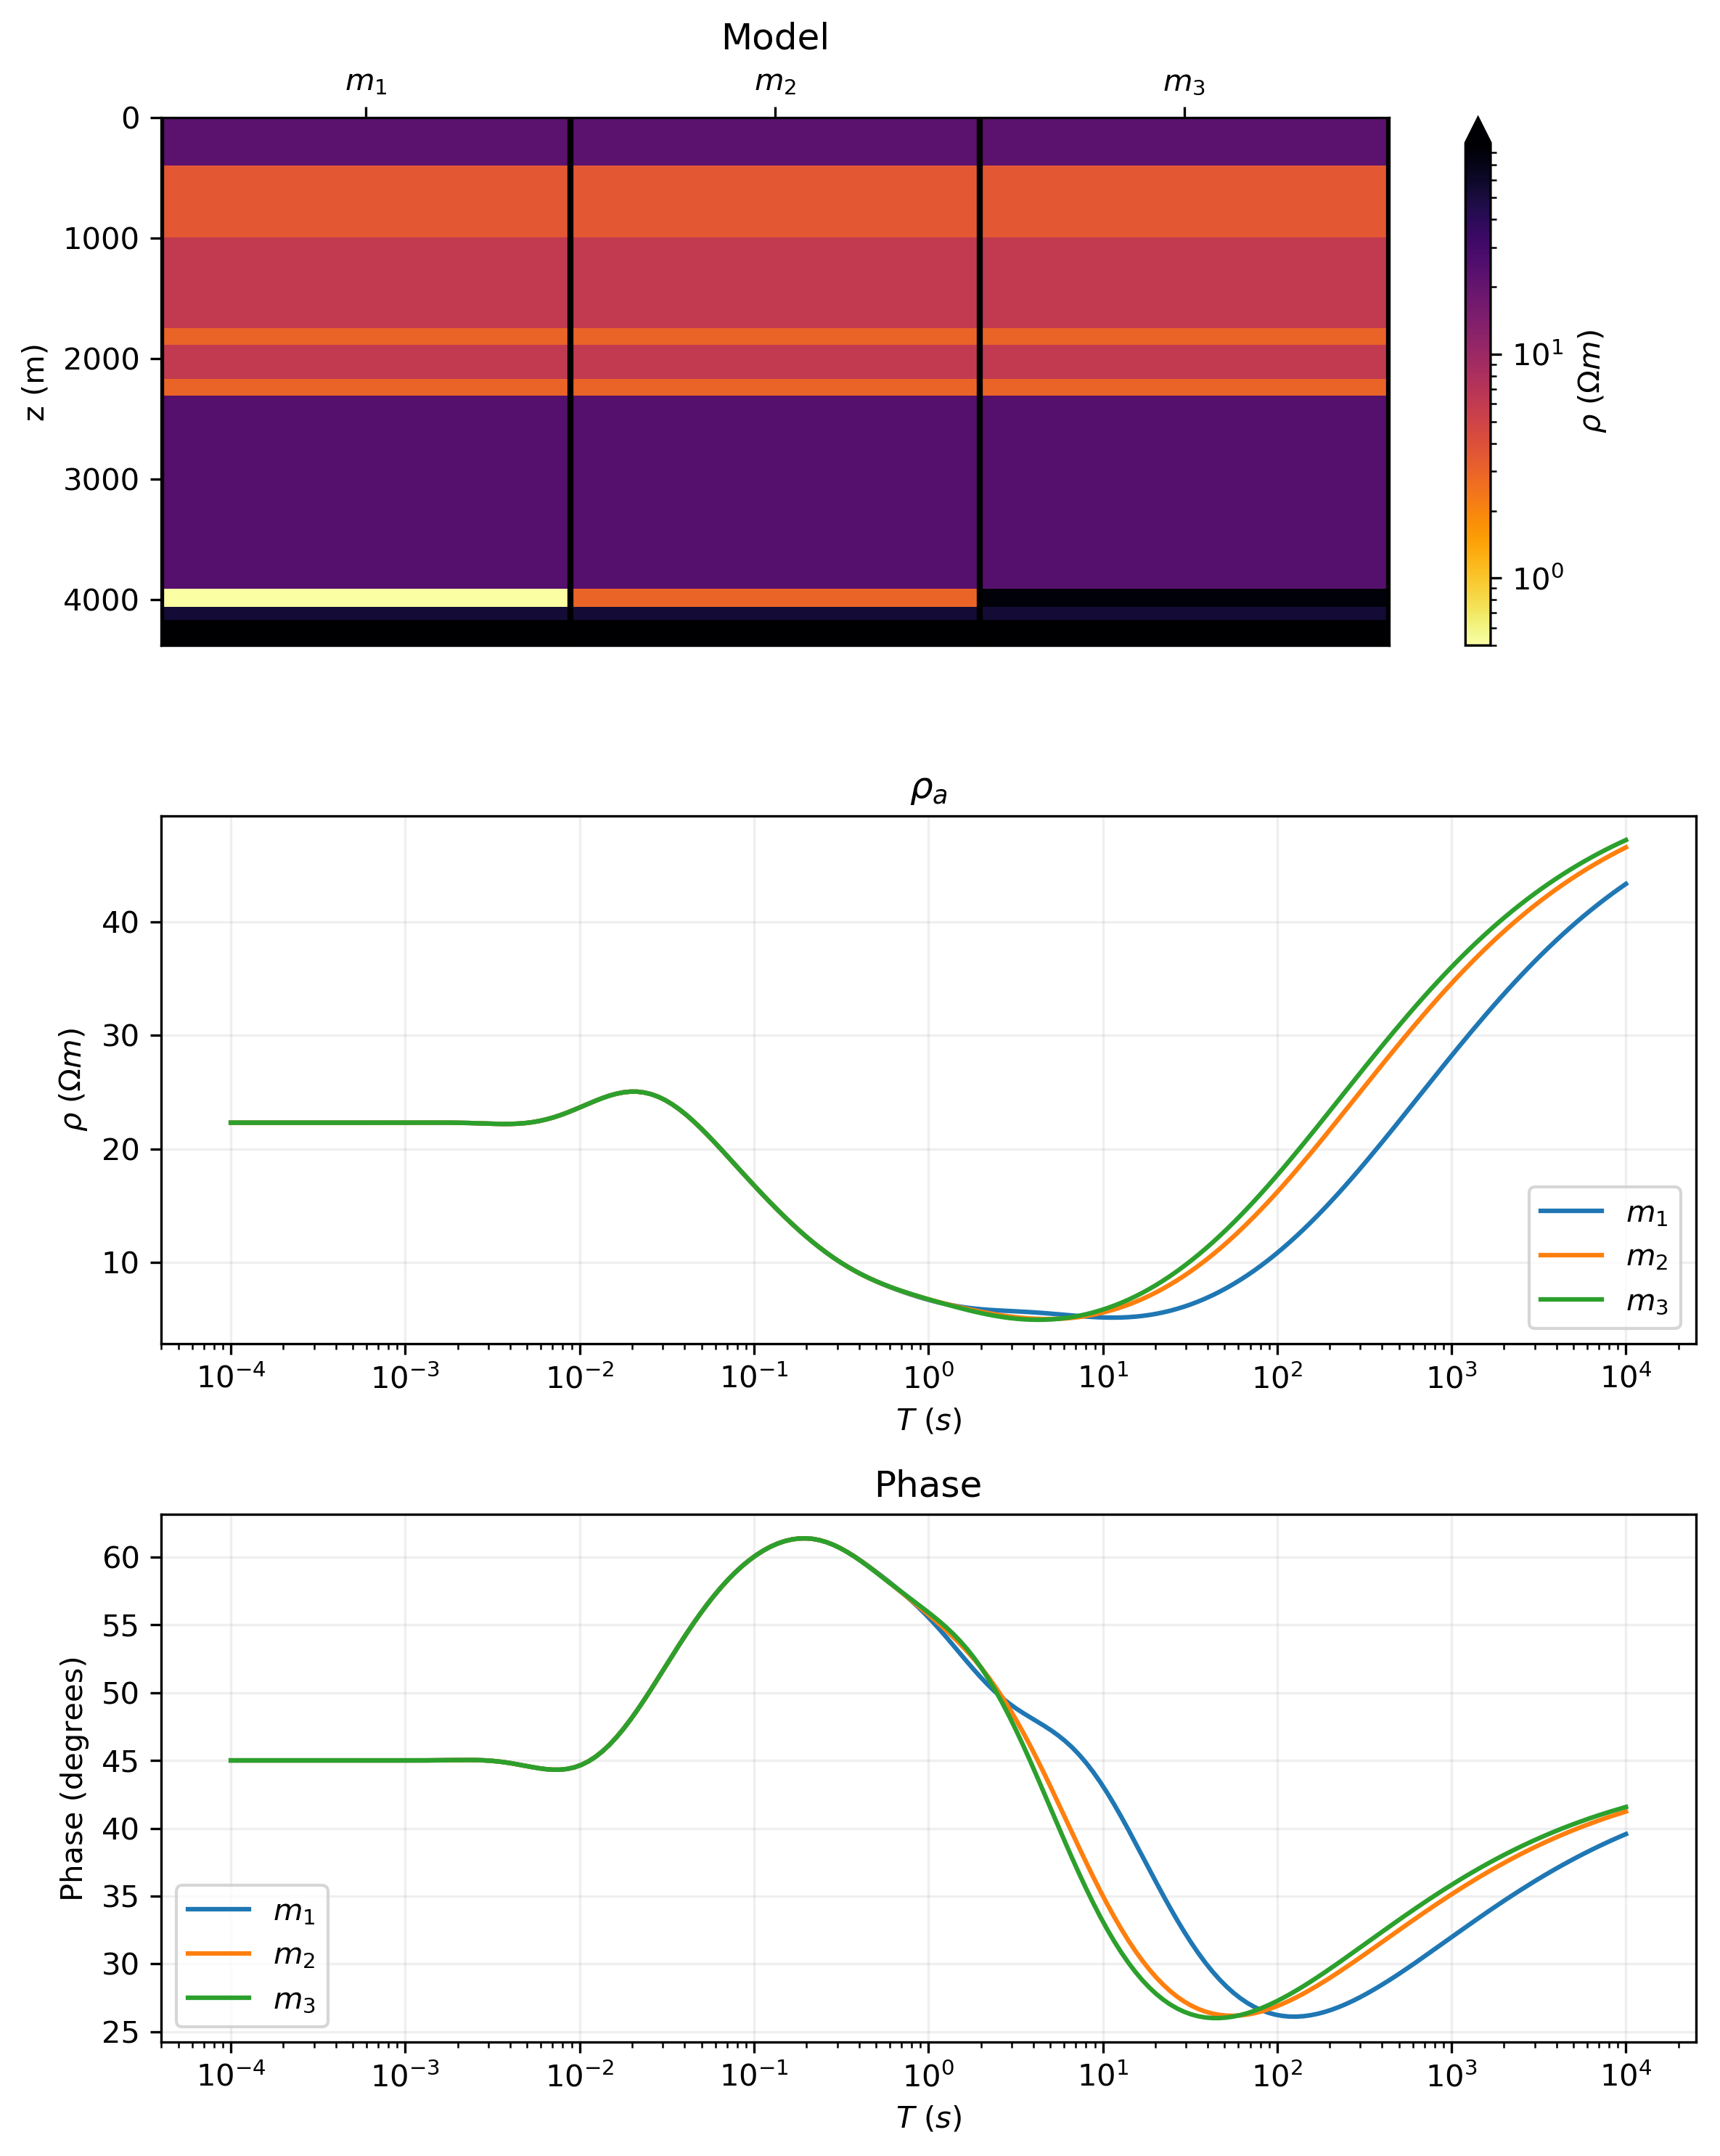

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

MU0 = 4 * np.pi * 1e-7  # H/m or N/A²
DPI = 100


def forward_mt1d(rho, h, freq):
    '''
    Performs 1D magnetotelurics forward modeling. rho and h are sequences of
    resistivities and layer thicknesses, respectively, while freq is a sequence
    of listened frequency bands. Returns Aparent resistivities (rhoa) and
    impedance phases (phi).
    '''
    n_layers, n_freq = len(h), len(freq)
    rhoa = np.empty(n_freq)
    phi = np.empty(n_freq)

    for i, f in enumerate(freq):
        w = 2 * np.pi * f
        z = np.empty(n_layers + 1, dtype=np.complex)
        z[-1] = np.sqrt(1j * w * MU0 * rho[-1])

        for j in range(n_layers - 1, -1, -1):
            dj = np.sqrt(1j * (w * MU0 / rho[j]))
            wj = dj * rho[j]
            ej = np.exp(-2 * h[j] * dj)

            rj = (wj - z[j + 1]) / (wj + z[j + 1])
            re = rj * ej
            z[j] = wj * (1 - re) / (1 + re)

        rhoa[i] = np.abs(z[0])**2 / (MU0 * w)
        phi[i] = np.degrees(np.angle(z[0]))
    return rhoa, phi


def gen_rho(rho_sandstone=3):
    # return [100, 30, 130, rho_sandstone, 200, 190, 180]  # ohmm
    return [
        22.3,
        3.5,
        6,
        3,
        6,
        3,
        24.6,
        rho_sandstone,
        53.7,
    ]  # ohmm


def gen_h(h_sandstone=150):
    # return [430, 580, 1160, h_sandstone, 1600, 150]  # m
    return [
        400,
        600,
        750,
        140,
        280,
        140,
        1600,
        h_sandstone,
        110,
    ]  # m


if __name__ == '__main__':
    # defining model

    # fix rho
    # rhos = [gen_rho(r) for r in 3 * [3]]
    # fig_name = 'fix_rho.png'
    # hs = [gen_h(t) for t in (50, 150, 500)]

    # fix rho oil
    # rhos = [gen_rho(r) for r in 3 * [20]]
    # fig_name = 'fix_rho_oil.png'
    # hs = [gen_h(t) for t in (50, 150, 500)]

    # fix h
    rhos = [gen_rho(r) for r in (.5, 3, 80)]
    fig_name = 'fix_h.png'
    hs = [gen_h(t) for t in 3 * [150]]

    # print(rhos[1])
    # print(hs[1])
    # exit()

    # defining sampling frequencies
    # freq = [0.0001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 10000]  # Hz
    # freq = np.asarray(freq)
    freq = 10**(np.linspace(-4, 4, 200))  # Hz

    z_max = 1.05 * np.max([np.sum(h) for h in hs])
    rho_max = 1.05 * np.max([np.sum(rho) for rho in rhos])
    print(z_max)
    # exit()
    nz = np.int(z_max)
    z_ax = np.linspace(0, z_max, nz)

    # writing model grid
    model = np.empty((nz, len(hs)))
    for j, (rho, h) in enumerate(zip(rhos, hs)):
        z = np.cumsum([0, *h])
        for i in range(0, len(z) - 1):
            model[(z[i] <= z_ax) & (z_ax < z[i + 1]), j] = rho[i]
        model[z_ax >= z[-1], j] = 2 * rho_max

    # plotting results
    fig, (ax_mod, ax_fwd, ax_fwd_tw) = plt.subplots(3,
                                                    1,
                                                    figsize=(8, 10),
                                                    dpi=DPI)

    # plotting model
    im = ax_mod.imshow(model,
                       norm=colors.LogNorm(vmin=model.min(), vmax=model.max()),
                       aspect='auto',
                       extent=(0, len(rhos), z_max, 0),
                       cmap='inferno_r',
                       interpolation='nearest',
                       vmax=1.1 * np.max(rho))
    cax = plt.colorbar(im, ax=ax_mod, orientation='vertical', extend='max')
    cax.set_label('$\\rho$ $(\\Omega m)$')
    ax_mod.set_title('Model')
    ax_mod.set_ylabel('z (m)')
    ax_mod.set_xticks([i + .5 for i in range(len(rhos))])
    ax_mod.set_xticklabels([f'$m_{i}$' for i in range(1, len(rhos) + 1)])
    for i in range(0, 1 + len(hs)):
        ax_mod.axvline(i, color='black', lw=2)
    ax_mod.xaxis.tick_top()

    # plotting modeling results
    T = 1 / freq
    ax_fwd.set_title('$\\rho_a$')
    ax_fwd_tw.set_title('Phase')
    for i, (rho, h) in enumerate(zip(rhos, hs), start=1):
        # performing modeling
        rhoa, phi = forward_mt1d(rho, h, freq)
        plot_rhoa = ax_fwd.plot(T, rhoa, label=f'$m_{i}$')
        plot_phi = ax_fwd_tw.plot(T, phi, label=f'$m_{i}$')

    ax_fwd.grid(alpha=.2)
    ax_fwd_tw.grid(alpha=.2)
    ax_fwd.legend(loc='lower right')
    ax_fwd_tw.legend(loc='lower left')
    ax_fwd.set_xlabel('$T$ $(s)$')
    ax_fwd.set_ylabel('$\\rho$ $(\\Omega m)$')
    ax_fwd_tw.set_xlabel('$T$ $(s)$')
    ax_fwd_tw.set_ylabel('Phase (degrees)')

    for ax in [ax_fwd, ax_fwd_tw]:
        ax.set_xscale('log')
        # ax.set_yscale('log')

    plt.tight_layout()
    #plt.savefig(fig_name)
    plt.show()

#     # printing results
#     for freq_i, rhoa_i, phi_i in zip(freq, rhoa, phi):
#         print(freq_i, T, rhoa_i, phi_i, sep='\t')